# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=40,
        fold=2,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_13-47-43/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192008 [00:00<?, ?it/s]

  0%|          | 0/53239 [00:00<?, ?it/s]

  0%|          | 0/21405 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4917 | MulticlassF1Score=0.1470
Batch-30 : CrossEntropyLoss=2.4664 | MulticlassF1Score=0.2061
Batch-45 : CrossEntropyLoss=2.4438 | MulticlassF1Score=0.2370
Batch-60 : CrossEntropyLoss=2.4414 | MulticlassF1Score=0.2622
Batch-75 : CrossEntropyLoss=2.4213 | MulticlassF1Score=0.2968
Batch-90 : CrossEntropyLoss=2.4315 | MulticlassF1Score=0.3269
Batch-105: CrossEntropyLoss=2.4177 | MulticlassF1Score=0.3467
Batch-120: CrossEntropyLoss=2.3766 | MulticlassF1Score=0.3705
Batch-135: CrossEntropyLoss=2.3915 | MulticlassF1Score=0.3953
Batch-150: CrossEntropyLoss=2.3654 | MulticlassF1Score=0.4137
Batch-165: CrossEntropyLoss=2.3897 | MulticlassF1Score=0.4306
Batch-180: CrossEntropyLoss=2.3658 | MulticlassF1Score=0.4443
Batch-195: CrossEntropyLoss=2.3636 | MulticlassF1Score=0.4561
Batch-210: CrossEntropyLoss=2.3602 | MulticlassF1Score=0.4682
Batch-225: CrossEntropyLoss=2.3591 | MulticlassF1Score=0.4811
Batch-226: CrossEntropyLoss=2.3483 | MulticlassF1Score=0.4817

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3503 | MulticlassF1Score=0.6766
Batch-30 : CrossEntropyLoss=2.3571 | MulticlassF1Score=0.6759
Batch-45 : CrossEntropyLoss=2.3409 | MulticlassF1Score=0.6725
Batch-60 : CrossEntropyLoss=2.3661 | MulticlassF1Score=0.6724
Batch-63 : CrossEntropyLoss=2.3566 | MulticlassF1Score=0.6726

Training   : Mean CrossEntropyLoss = 2.4179 | Mean MulticlassF1Score = 0.3400
Validation : Mean CrossEntropyLoss = 2.3505 | Mean MulticlassF1Score = 0.6760

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3456 | MulticlassF1Score=0.6680
Batch-30 : CrossEntropyLoss=2.3522 | MulticlassF1Score=0.6843
Batch-45 : CrossEntropyLoss=2.3437 | MulticlassF1Score=0.6926
Batch-60 : CrossEntropyLoss=2.3365 | MulticlassF1Score=0.6961
Batch-75 : CrossEntropyLoss=2.3395 | MulticlassF1Score=0.6995
Batch-90 : CrossEntropyLoss=2.3403 | MulticlassF1Score=0.7029
Batch-105: CrossEntropyLoss=2.3284 | MulticlassF1Score=0.7057
Batch-120: CrossEntropyLoss=2.3193 | MulticlassF1Score=0.7068
Batch-135: CrossEntropyLoss=2.3257 | MulticlassF1Score=0.7093
Batch-150: CrossEntropyLoss=2.3305 | MulticlassF1Score=0.7100
Batch-165: CrossEntropyLoss=2.3429 | MulticlassF1Score=0.7110
Batch-180: CrossEntropyLoss=2.3346 | MulticlassF1Score=0.7117
Batch-195: CrossEntropyLoss=2.3347 | MulticlassF1Score=0.7127
Batch-210: CrossEntropyLoss=2.3316 | MulticlassF1Score=0.7131
Batch-225: CrossEntropyLoss=2.3248 | MulticlassF1Score=0.7142
Batch-226: CrossEntropyLoss=2.3295 | MulticlassF1Score=0.7142

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3281 | MulticlassF1Score=0.7235
Batch-30 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7262
Batch-45 : CrossEntropyLoss=2.3249 | MulticlassF1Score=0.7258
Batch-60 : CrossEntropyLoss=2.3412 | MulticlassF1Score=0.7246
Batch-63 : CrossEntropyLoss=2.3292 | MulticlassF1Score=0.7250

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3372 | Mean MulticlassF1Score = 0.7013
Validation : Mean CrossEntropyLoss = 2.3330 | Mean MulticlassF1Score = 0.7232

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3186 | MulticlassF1Score=0.7299
Batch-30 : CrossEntropyLoss=2.3378 | MulticlassF1Score=0.7270
Batch-45 : CrossEntropyLoss=2.3273 | MulticlassF1Score=0.7341
Batch-60 : CrossEntropyLoss=2.3204 | MulticlassF1Score=0.7421
Batch-75 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.7506
Batch-90 : CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7574
Batch-105: CrossEntropyLoss=2.3122 | MulticlassF1Score=0.7633
Batch-120: CrossEntropyLoss=2.3113 | MulticlassF1Score=0.7673
Batch-135: CrossEntropyLoss=2.3144 | MulticlassF1Score=0.7696
Batch-150: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7714
Batch-165: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7735
Batch-180: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.7751
Batch-195: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7768
Batch-210: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7783
Batch-225: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.7801
Batch-226: CrossEntropyLoss=2.3158 | MulticlassF1Score=0.7800

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.7976
Batch-30 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.7972
Batch-45 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7965
Batch-60 : CrossEntropyLoss=2.3176 | MulticlassF1Score=0.7938
Batch-63 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7941

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3164 | Mean MulticlassF1Score = 0.7583
Validation : Mean CrossEntropyLoss = 2.3118 | Mean MulticlassF1Score = 0.7977

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.7918
Batch-30 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.7946
Batch-45 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.7951
Batch-60 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.7973
Batch-75 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8003
Batch-90 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8014
Batch-105: CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8018
Batch-120: CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8028
Batch-135: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8033
Batch-150: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8043
Batch-165: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8059
Batch-180: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8077
Batch-195: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8093
Batch-210: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8110
Batch-225: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8122
Batch-226: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8122

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3154 | MulticlassF1Score=0.8251
Batch-30 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8261
Batch-45 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8258
Batch-60 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8241
Batch-63 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3062 | Mean MulticlassF1Score = 0.8027
Validation : Mean CrossEntropyLoss = 2.3025 | Mean MulticlassF1Score = 0.8253

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8353
Batch-30 : CrossEntropyLoss=2.3143 | MulticlassF1Score=0.8346
Batch-45 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8327
Batch-60 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8312
Batch-75 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8309
Batch-90 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8299
Batch-105: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8295
Batch-120: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8306
Batch-135: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8301
Batch-150: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8296
Batch-165: CrossEntropyLoss=2.3090 | MulticlassF1Score=0.8299
Batch-180: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8297
Batch-195: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8299
Batch-210: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8301
Batch-225: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8303
Batch-226: CrossEntropyLoss=2.3159 | MulticlassF1Score=0.8302

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8345
Batch-30 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8294
Batch-45 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8294
Batch-60 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8281
Batch-63 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3005 | Mean MulticlassF1Score = 0.8314
Validation : Mean CrossEntropyLoss = 2.3011 | Mean MulticlassF1Score = 0.8304

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8323
Batch-30 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8353
Batch-45 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8345
Batch-60 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8334
Batch-75 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8331
Batch-90 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8328
Batch-105: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8323
Batch-120: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8321
Batch-135: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8333
Batch-150: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8333
Batch-165: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8341
Batch-180: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8338
Batch-195: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8347
Batch-210: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8352
Batch-225: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8357
Batch-226: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8357

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8359
Batch-30 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8373
Batch-45 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8355
Batch-60 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8371
Batch-63 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8369

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8333
Validation : Mean CrossEntropyLoss = 2.2982 | Mean MulticlassF1Score = 0.8367

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8485
Batch-30 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8480
Batch-45 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8453
Batch-60 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8447
Batch-75 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8438
Batch-90 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8432
Batch-105: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8428
Batch-120: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8421
Batch-135: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8419
Batch-150: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8421
Batch-165: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8424
Batch-180: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8423
Batch-195: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8430
Batch-210: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8432
Batch-225: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8442
Batch-226: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8443

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8471
Batch-30 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8488
Batch-45 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8497
Batch-60 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8510
Batch-63 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8514

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2960 | Mean MulticlassF1Score = 0.8442
Validation : Mean CrossEntropyLoss = 2.2939 | Mean MulticlassF1Score = 0.8492

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8581
Batch-30 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8588
Batch-45 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8594
Batch-60 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8599
Batch-75 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8595
Batch-90 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8594
Batch-105: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8595
Batch-120: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8593
Batch-135: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8595
Batch-150: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8592
Batch-165: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8596
Batch-180: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8598
Batch-195: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8595
Batch-210: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8599
Batch-225: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8597
Batch-226: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8598

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8529
Batch-30 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8545
Batch-45 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8557
Batch-60 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8552
Batch-63 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8550

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2914 | Mean MulticlassF1Score = 0.8597
Validation : Mean CrossEntropyLoss = 2.2926 | Mean MulticlassF1Score = 0.8550

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8669
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8630
Batch-45 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8614
Batch-60 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8614
Batch-75 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8623
Batch-90 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8613
Batch-105: CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8605
Batch-120: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8607
Batch-135: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8610
Batch-150: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8606
Batch-165: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8602
Batch-180: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8603
Batch-195: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8605
Batch-210: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8611
Batch-225: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8613
Batch-226: CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8612

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8530
Batch-30 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8568
Batch-45 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8551
Batch-60 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8550
Batch-63 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8548

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2908 | Mean MulticlassF1Score = 0.8615
Validation : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8553

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8608
Batch-30 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8596
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8604
Batch-60 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8593
Batch-75 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8603
Batch-90 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8611
Batch-105: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8613
Batch-120: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8615
Batch-135: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8618
Batch-150: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8621
Batch-165: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8624
Batch-180: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8626
Batch-195: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8629
Batch-210: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8628
Batch-225: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8625
Batch-226: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8625

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8485
Batch-30 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8545
Batch-45 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8536
Batch-60 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8538
Batch-63 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8540

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2903 | Mean MulticlassF1Score = 0.8612
Validation : Mean CrossEntropyLoss = 2.2929 | Mean MulticlassF1Score = 0.8537

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8632
Batch-30 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8609
Batch-45 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8608
Batch-60 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8595
Batch-75 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8597
Batch-90 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8612
Batch-105: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8617
Batch-120: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8614
Batch-135: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8614
Batch-150: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8619
Batch-165: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8622
Batch-180: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8626
Batch-195: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8628
Batch-210: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8629
Batch-225: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8633
Batch-226: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8633

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8633
Batch-30 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8606
Batch-45 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8591
Batch-60 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8560
Batch-63 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8558

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2899 | Mean MulticlassF1Score = 0.8616
Validation : Mean CrossEntropyLoss = 2.2923 | Mean MulticlassF1Score = 0.8606

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8664
Batch-30 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8667
Batch-45 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8652
Batch-60 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8649
Batch-75 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8642
Batch-90 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8646
Batch-105: CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8657
Batch-120: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8682
Batch-135: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8708
Batch-150: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8722
Batch-165: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8736
Batch-180: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8751
Batch-195: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8766
Batch-210: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8774
Batch-225: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8782
Batch-226: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8782

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8836
Batch-30 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8799
Batch-45 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8831
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8824
Batch-63 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8822

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2855 | Mean MulticlassF1Score = 0.8699
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8824

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8944
Batch-30 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8938
Batch-45 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8921
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8926
Batch-75 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8921
Batch-90 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8932
Batch-105: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8934
Batch-120: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8934
Batch-135: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8943
Batch-150: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8944
Batch-165: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8943
Batch-180: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8940
Batch-195: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8941
Batch-210: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8938
Batch-225: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8940
Batch-226: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8939

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8884
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8875
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8867
Batch-60 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8854
Batch-63 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8854

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8932
Validation : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8883

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8958
Batch-30 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8982
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.8973
Batch-60 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8955
Batch-75 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8959
Batch-90 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8956
Batch-105: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8960
Batch-120: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8969
Batch-135: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8965
Batch-150: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8962
Batch-165: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8962
Batch-180: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8960
Batch-195: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8963
Batch-210: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8960
Batch-225: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8958
Batch-226: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8957

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8850
Batch-30 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8843
Batch-45 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8844
Batch-60 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8850
Batch-63 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8856

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2800 | Mean MulticlassF1Score = 0.8966
Validation : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8830

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8963
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8973
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8979
Batch-60 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8983
Batch-75 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8979
Batch-90 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8973
Batch-105: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8974
Batch-120: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8982
Batch-135: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8980
Batch-150: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8977
Batch-165: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8975
Batch-180: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8974
Batch-195: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8975
Batch-210: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8974
Batch-225: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8974
Batch-226: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8974

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8835
Batch-30 : CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8829
Batch-45 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8840
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8842
Batch-63 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8845

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2794 | Mean MulticlassF1Score = 0.8978
Validation : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8839

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8934
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8970
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8975
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8979
Batch-75 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8983
Batch-90 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8980
Batch-105: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8978
Batch-120: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8975
Batch-135: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.8977
Batch-150: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8979
Batch-165: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8980
Batch-180: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8985
Batch-195: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8984
Batch-210: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.8988
Batch-225: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8990
Batch-226: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8990

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8843
Batch-30 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8877
Batch-45 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8901
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8890
Batch-63 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8894

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2789 | Mean MulticlassF1Score = 0.8976
Validation : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8870

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9043
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9056
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9054
Batch-60 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9044
Batch-75 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9044
Batch-90 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9045
Batch-105: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9048
Batch-120: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9042
Batch-135: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9041
Batch-150: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9042
Batch-165: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.9041
Batch-180: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.9040
Batch-195: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9037
Batch-210: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9034
Batch-225: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9033
Batch-226: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9034

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8919
Batch-30 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8898
Batch-45 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8906
Batch-60 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8902
Batch-63 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8900

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2776 | Mean MulticlassF1Score = 0.9044
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8904

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9027
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9040
Batch-45 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.9040
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9051
Batch-75 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9055
Batch-90 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9059
Batch-105: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9054
Batch-120: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9062
Batch-135: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9062
Batch-150: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9054
Batch-165: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9056
Batch-180: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9054
Batch-195: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9054
Batch-210: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9052
Batch-225: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9051
Batch-226: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9052

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8914
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8908
Batch-45 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8901
Batch-60 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8905
Batch-63 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8901

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2770 | Mean MulticlassF1Score = 0.9051
Validation : Mean CrossEntropyLoss = 2.2817 | Mean MulticlassF1Score = 0.8914

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9059
Batch-30 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9063
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9072
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9070
Batch-75 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9065
Batch-90 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9071
Batch-105: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9070
Batch-120: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9066
Batch-135: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9065
Batch-150: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9062
Batch-165: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9066
Batch-180: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.9064
Batch-195: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9066
Batch-210: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9063
Batch-225: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9065
Batch-226: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9065

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8875
Batch-30 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8889
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8898
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8907
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8905

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2765 | Mean MulticlassF1Score = 0.9065
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8893

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9107
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9086
Batch-45 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9083
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9090
Batch-75 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9081
Batch-90 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9078
Batch-105: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9080
Batch-120: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9083
Batch-135: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9081
Batch-150: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9083
Batch-165: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9082
Batch-180: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9082
Batch-195: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9082
Batch-210: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9080
Batch-225: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9079
Batch-226: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.9078

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8903
Batch-45 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8912
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8913
Batch-63 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8912

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2762 | Mean MulticlassF1Score = 0.9082
Validation : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8903

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9068
Batch-30 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9090
Batch-45 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9088
Batch-60 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9095
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9108
Batch-90 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9103
Batch-105: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9097
Batch-120: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9095
Batch-135: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9093
Batch-150: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9093
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9092
Batch-180: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9092
Batch-195: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9094
Batch-210: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9093
Batch-225: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9090
Batch-226: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9090

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8921
Batch-30 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8913
Batch-45 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8934
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8936
Batch-63 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8930

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2757 | Mean MulticlassF1Score = 0.9088
Validation : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8916

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9148
Batch-30 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9144
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9116
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9113
Batch-75 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9106
Batch-90 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9109
Batch-105: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9106
Batch-120: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9102
Batch-135: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9103
Batch-150: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9104
Batch-165: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9101
Batch-180: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9104
Batch-195: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9104
Batch-210: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9107
Batch-225: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9104
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9105

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8949
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8915
Batch-45 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8917
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8931
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8935

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9111
Validation : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8926

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9106
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9108
Batch-45 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9105
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9114
Batch-75 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9118
Batch-90 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9116
Batch-105: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9115
Batch-120: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9110
Batch-135: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9107
Batch-150: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9110
Batch-165: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9107
Batch-180: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9109
Batch-195: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9110
Batch-210: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9110
Batch-225: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9111
Batch-226: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9111

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8929
Batch-30 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8918
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8941
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8932
Batch-63 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8931

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2750 | Mean MulticlassF1Score = 0.9112
Validation : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8925

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9079
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9114
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9124
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9117
Batch-75 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9114
Batch-90 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9109
Batch-105: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9114
Batch-120: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9118
Batch-135: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9116
Batch-150: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9118
Batch-165: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9114
Batch-180: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9116
Batch-195: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9116
Batch-210: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9116
Batch-225: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9116
Batch-226: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9117

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8944
Batch-30 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8951
Batch-45 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8932
Batch-60 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8934
Batch-63 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8933

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2748 | Mean MulticlassF1Score = 0.9111
Validation : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8951

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9109
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9121
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9111
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9119
Batch-75 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9124
Batch-90 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9127
Batch-105: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9124
Batch-120: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9122
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9123
Batch-150: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9126
Batch-165: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9127
Batch-180: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9129
Batch-195: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9128
Batch-210: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9126
Batch-225: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9123
Batch-226: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9122

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.8969
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8940
Batch-45 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8940
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8938
Batch-63 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8937

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9122
Validation : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8956

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9168
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9147
Batch-45 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9136
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9128
Batch-75 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9123
Batch-90 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9130
Batch-105: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9126
Batch-120: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9127
Batch-135: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9123
Batch-150: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9127
Batch-165: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9126
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9125
Batch-195: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9125
Batch-210: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9124
Batch-225: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9125
Batch-226: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9125

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8925
Batch-30 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8935
Batch-45 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8928
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8940
Batch-63 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8938

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2744 | Mean MulticlassF1Score = 0.9132
Validation : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8933

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9131
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9132
Batch-45 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9126
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9123
Batch-75 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9131
Batch-90 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9129
Batch-105: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9135
Batch-120: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9131
Batch-135: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9127
Batch-150: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9127
Batch-165: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9123
Batch-180: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9125
Batch-195: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9125
Batch-210: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9122
Batch-225: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9124
Batch-226: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9123

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8918
Batch-30 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8943
Batch-45 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8924
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.8920
Batch-63 : CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8919

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9131
Validation : Mean CrossEntropyLoss = 2.2810 | Mean MulticlassF1Score = 0.8920
Patience = 1/50❗

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9057
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9099
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9118
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9129
Batch-75 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9122
Batch-90 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9126
Batch-105: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9134
Batch-120: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9130
Batch-135: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9130
Batch-150: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9134
Batch-165: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9132
Batch-180: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9129
Batch-195: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9129
Batch-210: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9125
Batch-225: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9125
Batch-226: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9124

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8983
Batch-30 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8946
Batch-45 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8936
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8933
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.8941

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9118
Validation : Mean CrossEntropyLoss = 2.2802 | Mean MulticlassF1Score = 0.8961

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9127
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9134
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9134
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9142
Batch-75 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9142
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9148
Batch-105: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9148
Batch-120: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9144
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9141
Batch-150: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9140
Batch-165: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9143
Batch-180: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9142
Batch-195: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9142
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9140
Batch-225: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9140
Batch-226: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9140

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8963
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8961
Batch-45 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8937
Batch-60 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8940
Batch-63 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8941

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2741 | Mean MulticlassF1Score = 0.9140
Validation : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8954

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9149
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9158
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9145
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9151
Batch-75 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9150
Batch-90 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9148
Batch-105: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9168
Batch-120: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9196
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9214
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9238
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9257
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9267
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9280
Batch-210: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9288
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9297
Batch-226: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9296

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9210
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9223
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9222

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2694 | Mean MulticlassF1Score = 0.9204
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9213

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9431
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9434
Batch-90 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9431
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9424
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9426
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9426
Batch-150: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9429
Batch-165: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9426
Batch-180: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9424
Batch-195: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9422
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9424
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9424
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9424

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9240
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9241

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9425
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9244

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9428
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9429
Batch-75 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9429
Batch-90 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9432
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9435
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9431
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9432
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9432
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9433
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9433
Batch-210: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9434
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9434

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9216
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9234

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9433
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9230

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9434
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9440
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9436
Batch-90 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9435
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9438
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9443
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9438
Batch-165: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9436
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9439
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9439
Batch-225: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9231
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9236
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9248
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9245

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9435
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9230

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9465
Batch-75 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9461
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9459
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9457
Batch-120: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9454
Batch-150: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9450
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9449
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9445
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9445
Batch-226: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9445

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9231
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9229
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9246
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9241
Batch-63 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9239

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2646 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9232

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9415
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9455
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9453
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9455
Batch-135: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9455
Batch-150: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9455
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9450
Batch-180: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9449
Batch-225: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9447
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9193
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9231
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9237
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9241

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9220

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9449
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9453
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9454
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9452
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9451
Batch-150: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9449
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9454
Batch-180: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9454
Batch-195: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9453
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9453
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9453
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9202
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9260
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9240

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9448
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9240

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9464
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9455
Batch-90 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9453
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9445
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9443
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9445
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9447
Batch-180: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9446
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9449
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9451
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9452
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9452

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9273
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9262
Batch-60 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9243
Batch-63 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9244

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9453
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9254
Patience = 2/50❗

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9442
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9442
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9447
Batch-105: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9456
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9464
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9462
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9464
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9469
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9471
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9472
Batch-226: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9472

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9278
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9280
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9269

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9478
Batch-75 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9478
Batch-90 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9482
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9486
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9486
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9486
Batch-150: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9485
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9487
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9485
Batch-195: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9485
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9482
Batch-225: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9481
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9481

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9288
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9250
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9482
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9263

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9490
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9501
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9495
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9492
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9493
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9493
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9492
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9494
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9490
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9488
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9484
Batch-195: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9483
Batch-210: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9482
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9480
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9481

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9313
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9314
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9287
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9273
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9273

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9488
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9298
Patience = 3/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9506
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9490
Batch-75 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9488
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9488
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9485
Batch-120: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9486
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9485
Batch-150: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9483
Batch-165: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9483
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9484
Batch-195: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9482
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9481
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9480
Batch-226: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9480

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9278
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9278
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9271
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9269

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9488
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9277
Patience = 4/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9478
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9487
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9487
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9486
Batch-120: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9484
Batch-135: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9481
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9478
Batch-165: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9479
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9480
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9481
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9481
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9481
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9481

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9221
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9480
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9260

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9489
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9483
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9485
Batch-90 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9490
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9490
Batch-120: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9490
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9487
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9485
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9485
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9486
Batch-195: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9484
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9488
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9485
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9485

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9275
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9486
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9255

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9476
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9477
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9471
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9471
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9478
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9484
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9484
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9484
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9487
Batch-195: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9487
Batch-210: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9486
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9489
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9488

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9251
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9259
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9273
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9267

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9479
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9259

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9483
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9494
Batch-105: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9491
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9498
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9498
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9498
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9496
Batch-180: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9493
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9493
Batch-210: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9492
Batch-225: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9491
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9491

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9294
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9275
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9278

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9487
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9292

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9522
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9522
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9525
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9515
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9509
Batch-90 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9501
Batch-105: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9500
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9501
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9500
Batch-150: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9497
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9494
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9494
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9494
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9494
Batch-225: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9492
Batch-226: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9492

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9323
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9296
Batch-45 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9281
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9286
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9286

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9504
Validation : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9299

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9488
Batch-75 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9490
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9520
Batch-105: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9544
Batch-120: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9564
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9577
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9590
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9600
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9607
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9613
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9618
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9624
Batch-226: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9624

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9548
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9469

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9711
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9702
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9702
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9703
Batch-195: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9701
Batch-225: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9700
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9488
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9487
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9477

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9702
Batch-105: CrossEntropyLoss=2.2512 | MulticlassF1Score=0.9710
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9708
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9708
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9705
Batch-226: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9705

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9520
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9498
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9502

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2519 | MulticlassF1Score=0.9732
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9732
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9722
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9724
Batch-75 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9717
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9720
Batch-105: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9719
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9716
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9713
Batch-180: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9713
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9712
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9718
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9491

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2564
Best CrossEntropyLoss training    : 2.2633
Best MulticlassF1Score validation : 0.9718
Best MulticlassF1Score validation : 0.9491
Training duration                 : 2.3996 minutes.
Training date                     : 2022-10-19 10:16:33.173887+08:00


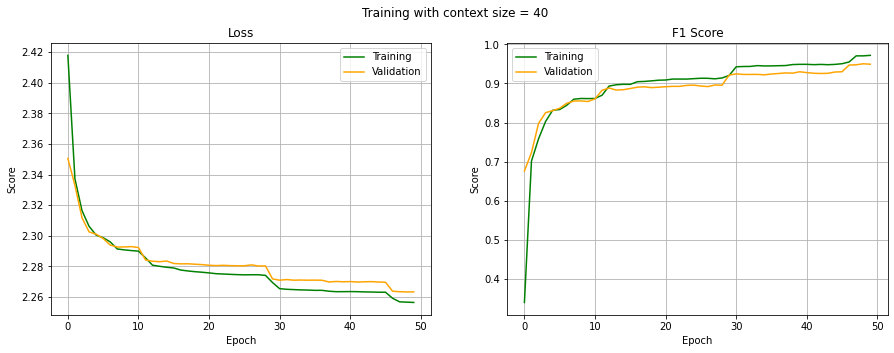

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9717, device='cuda:0'),
 tensor(0.9489, device='cuda:0'),
 tensor(0.9492, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9717, device='cuda:0'),
 tensor(0.9489, device='cuda:0'),
 tensor(0.9492, device='cuda:0'))

## Heatmap

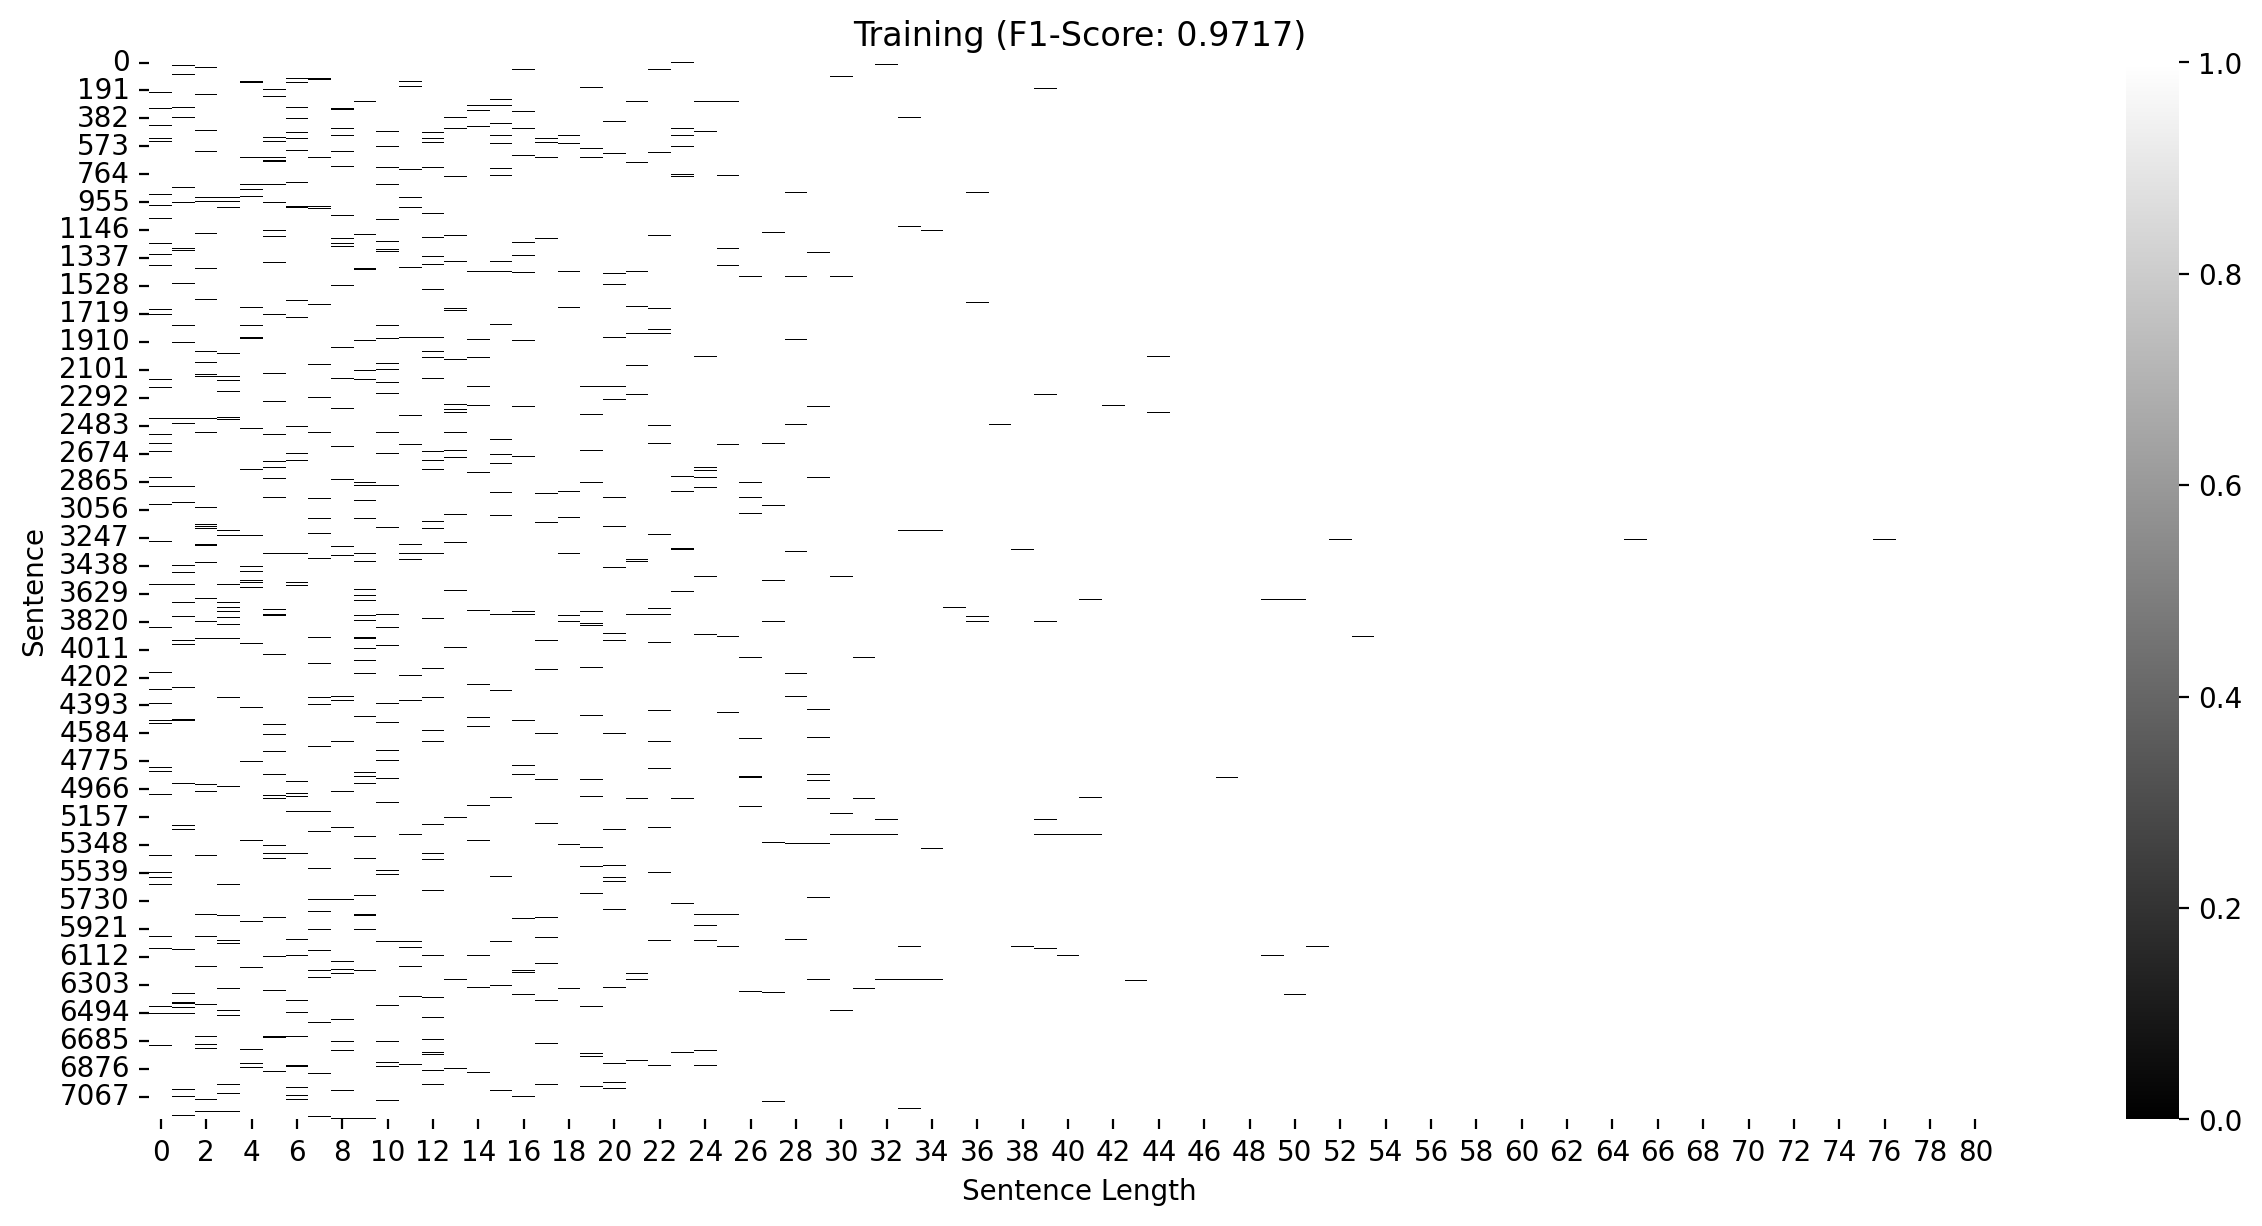

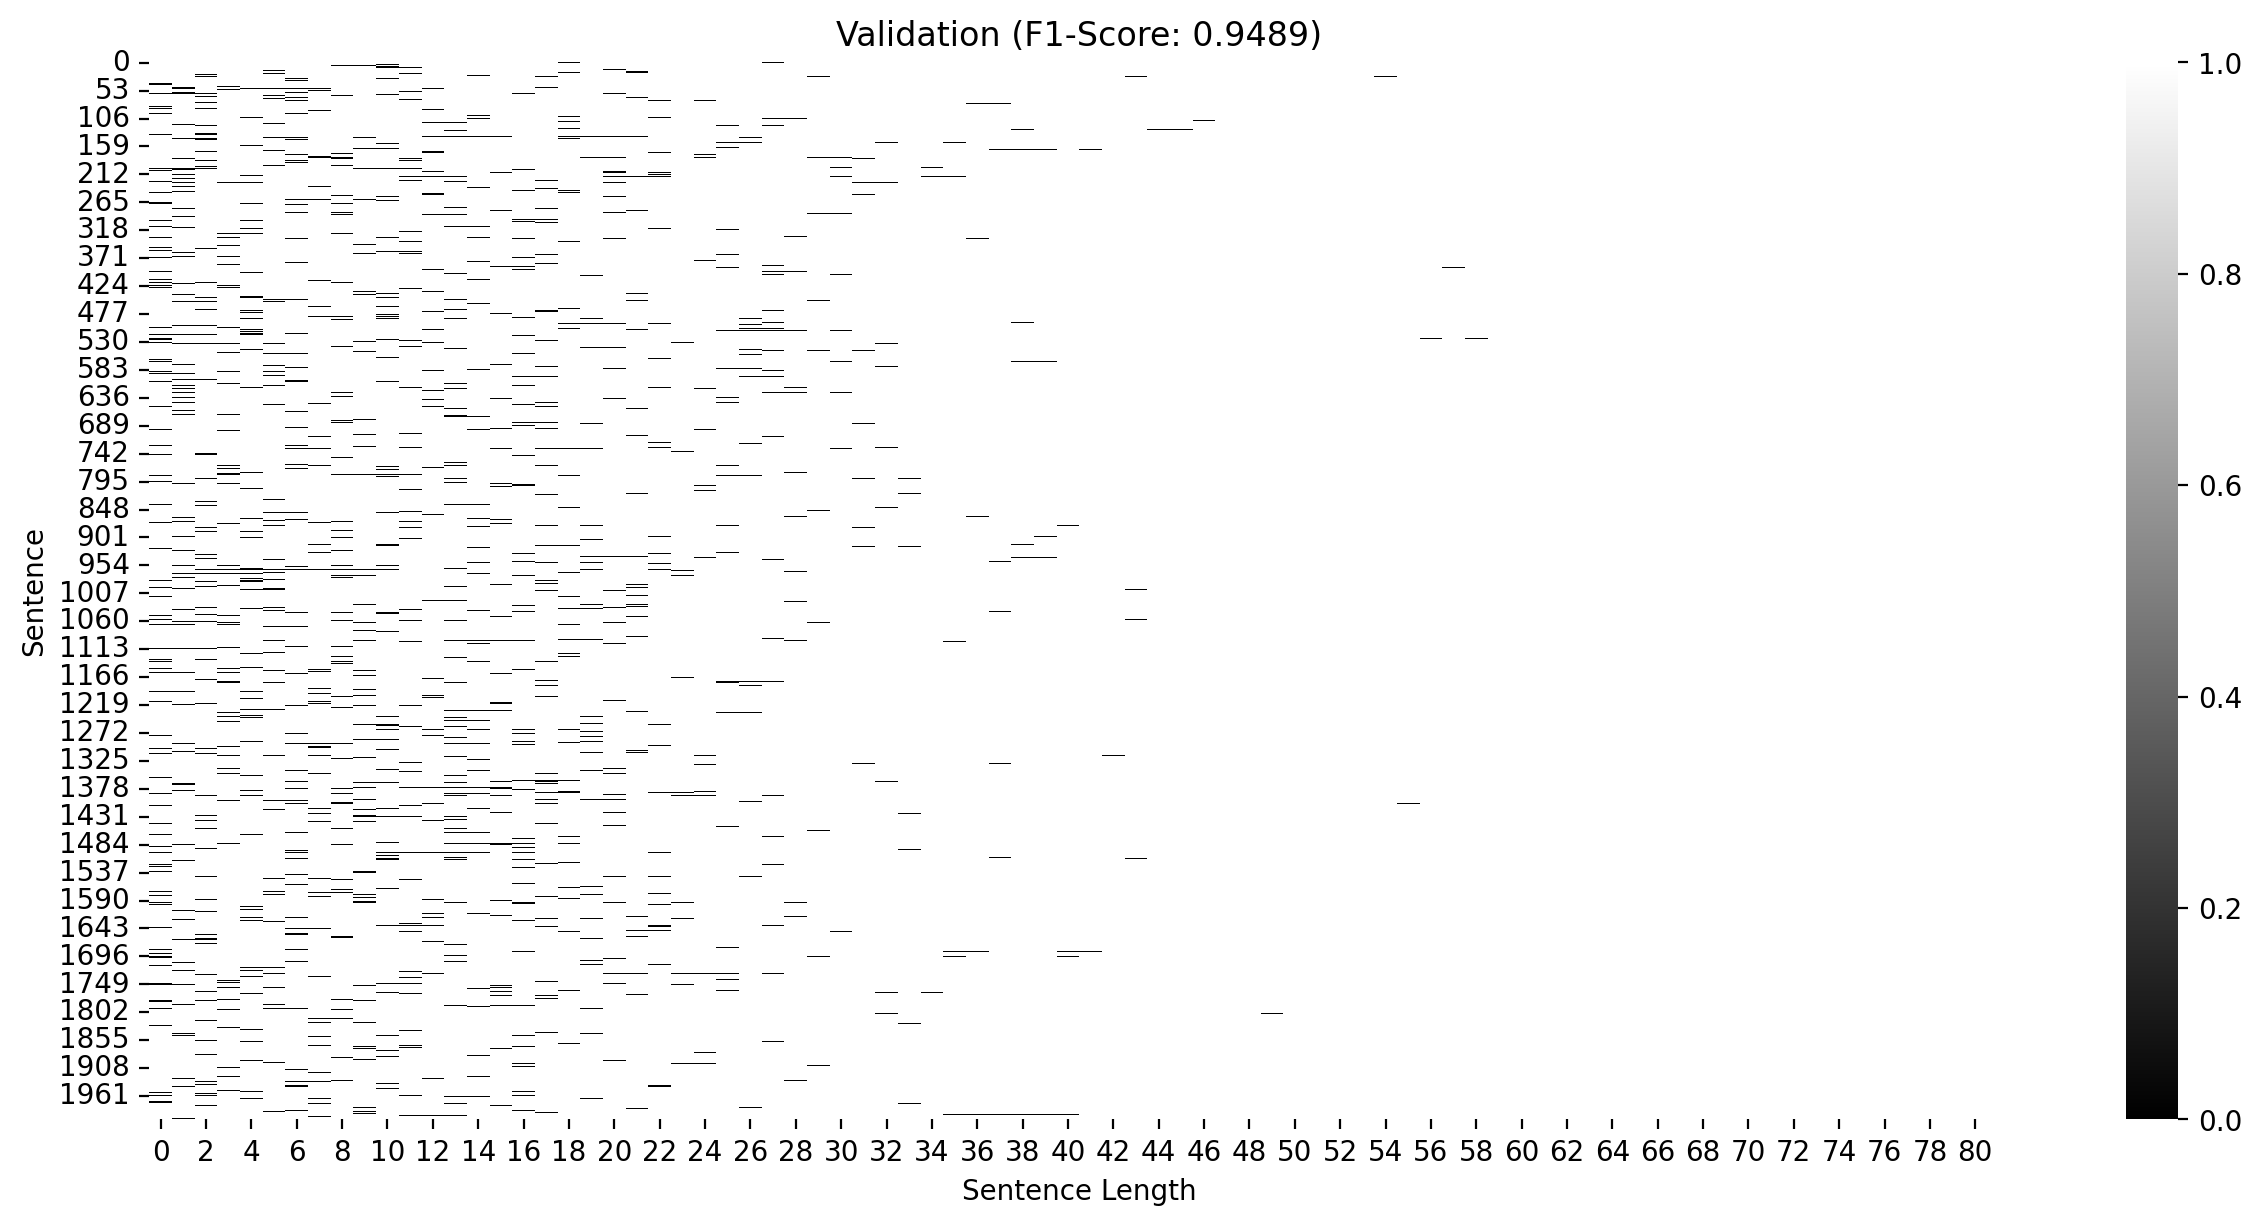

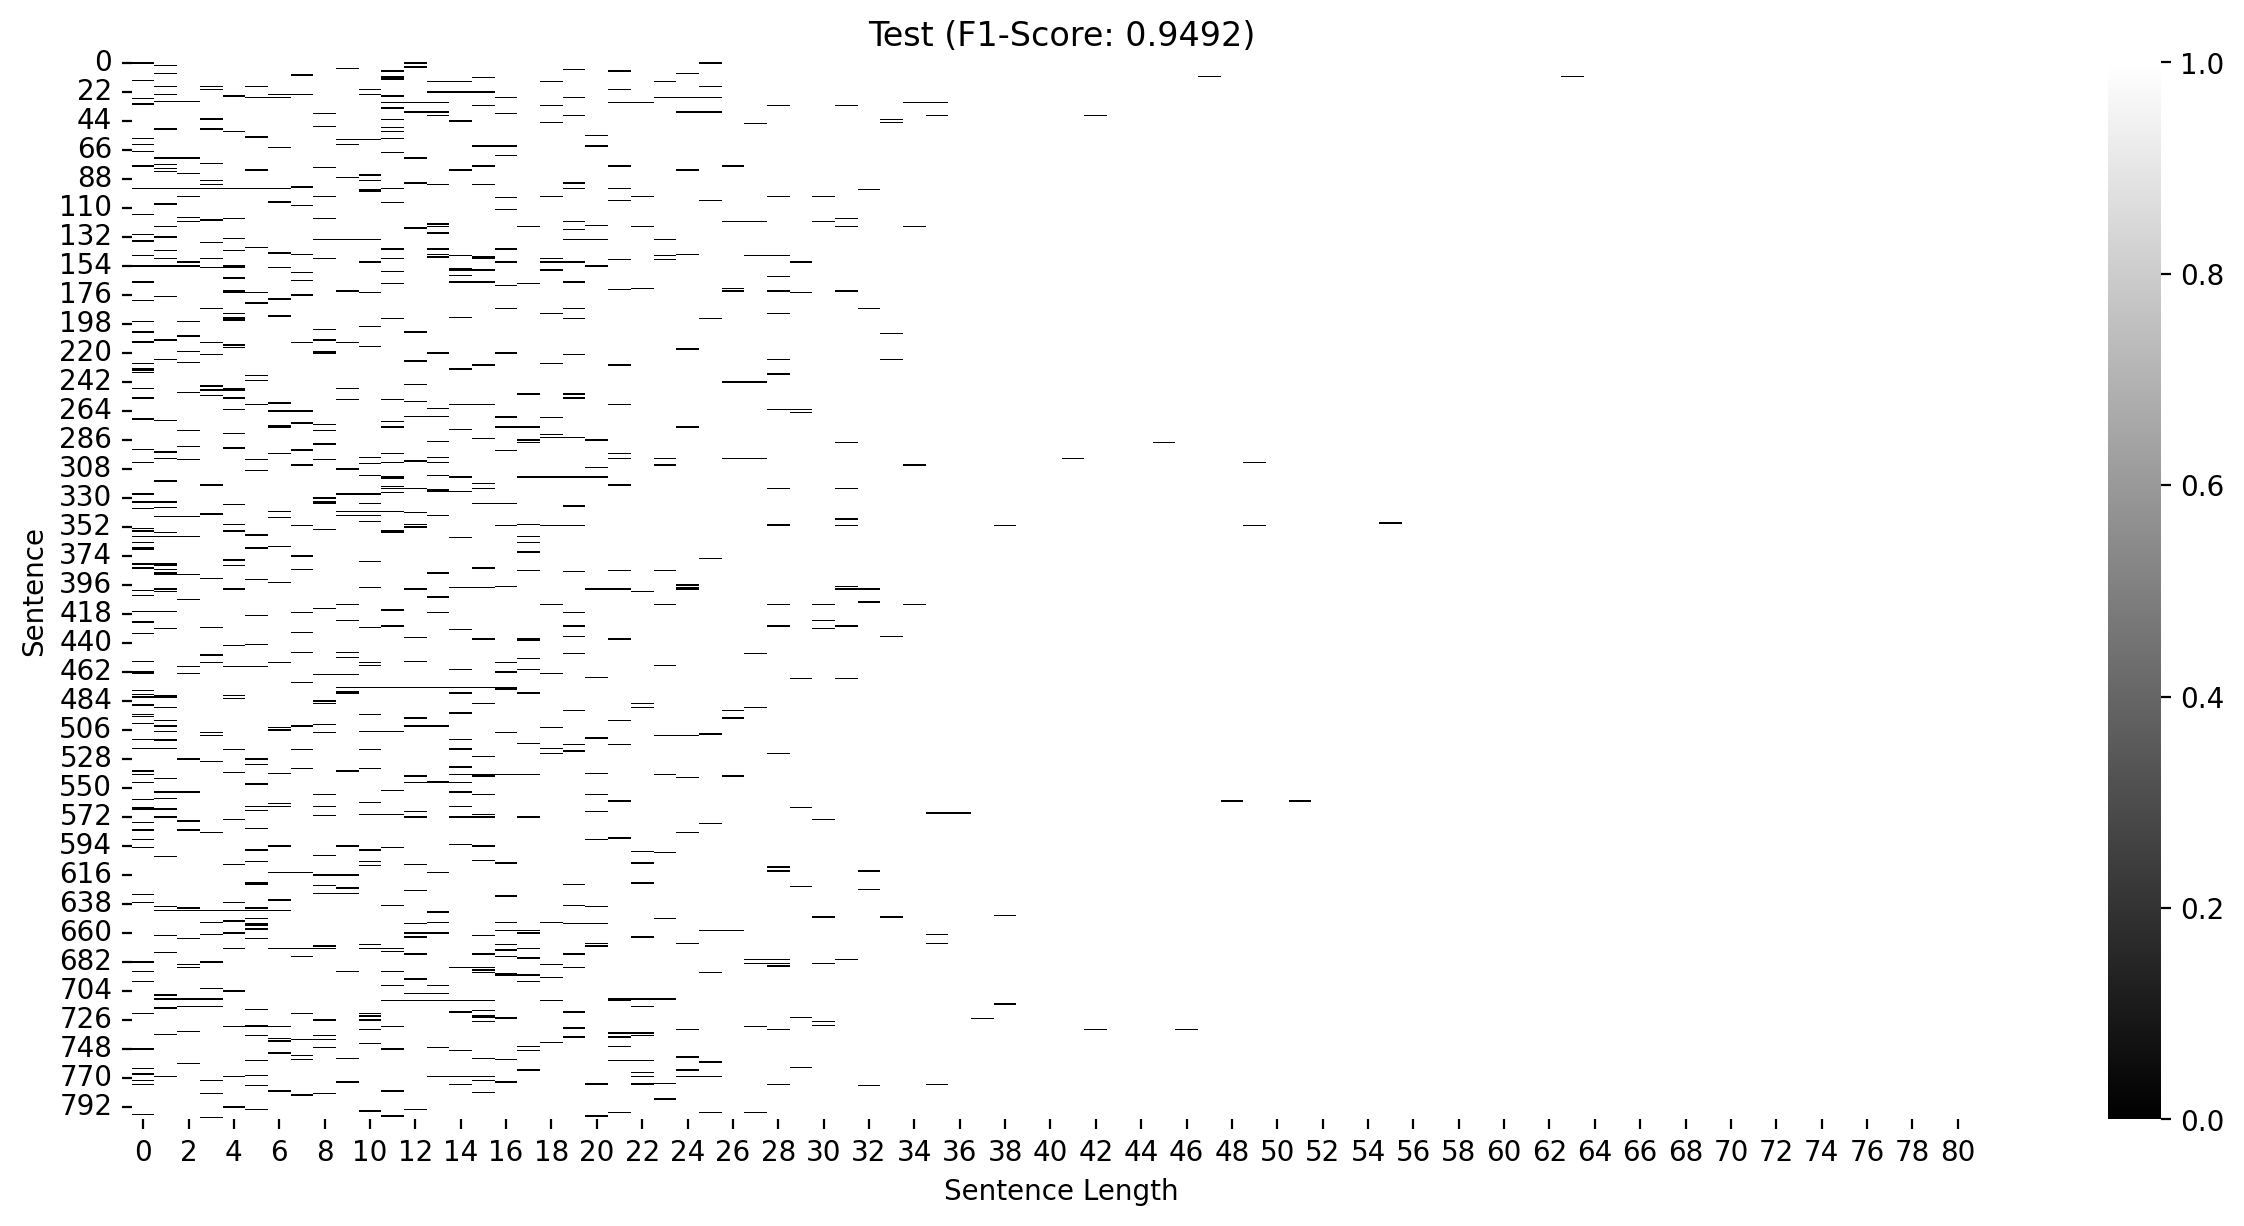

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


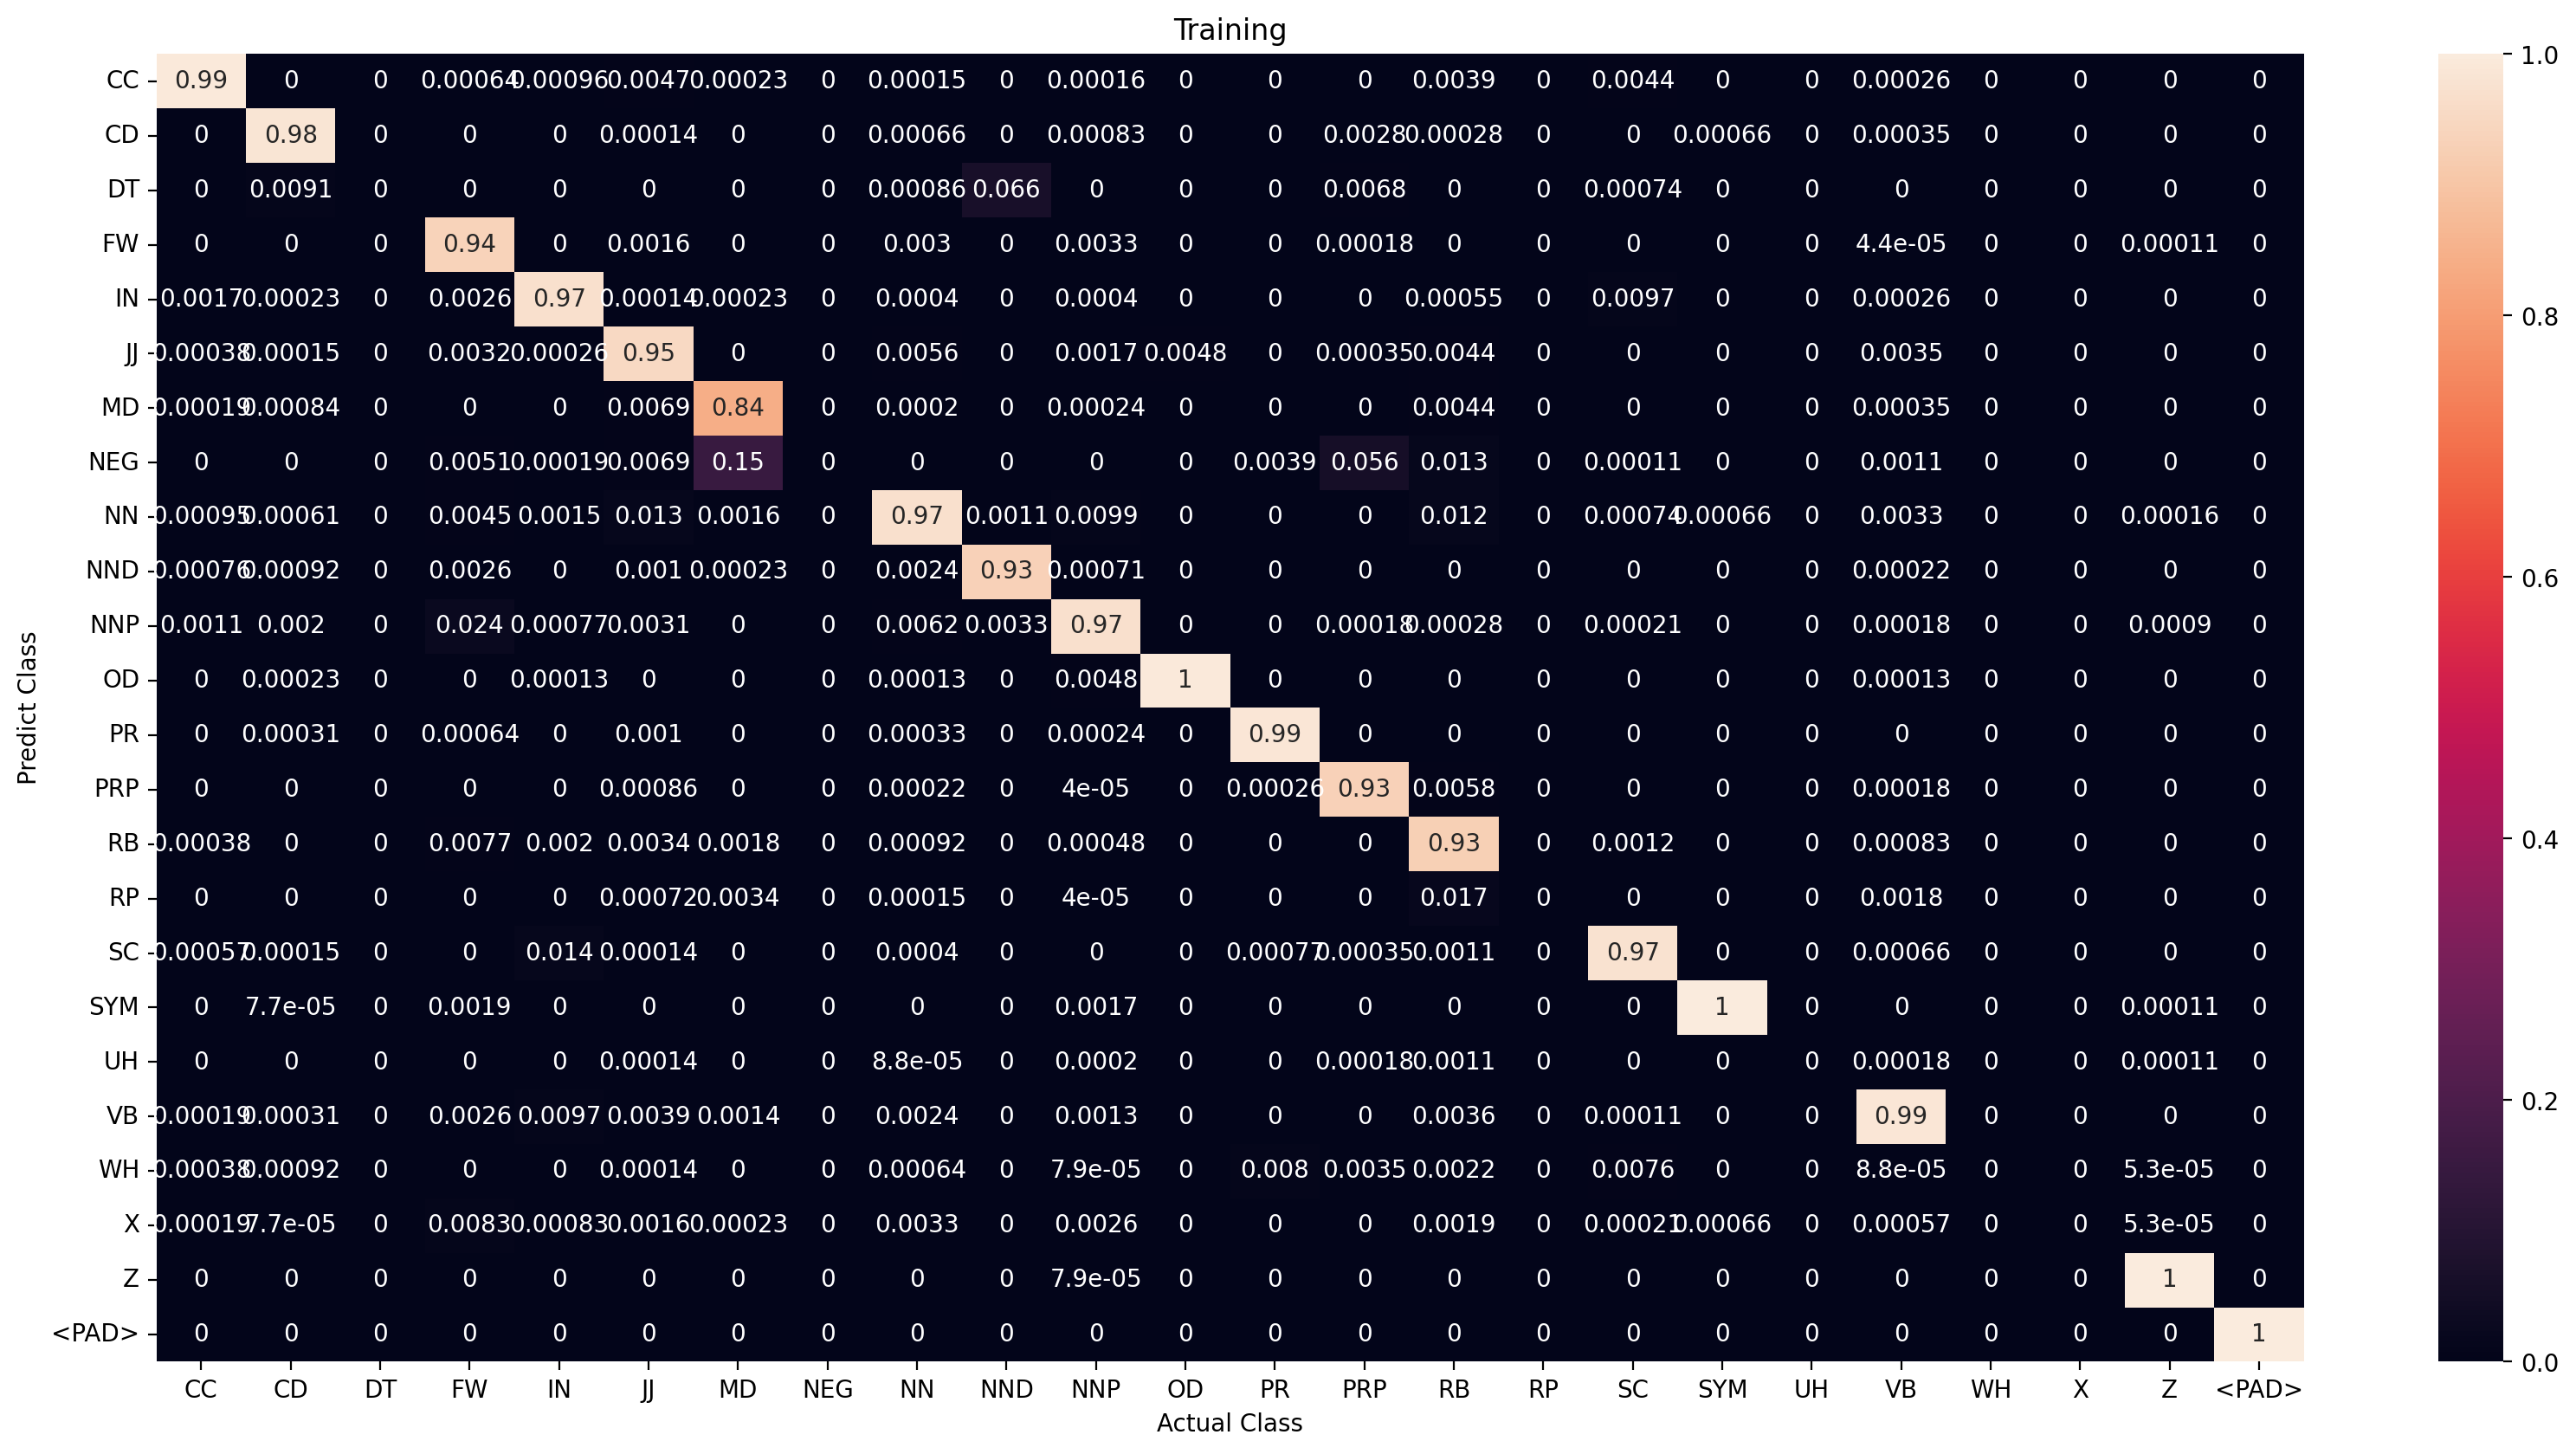

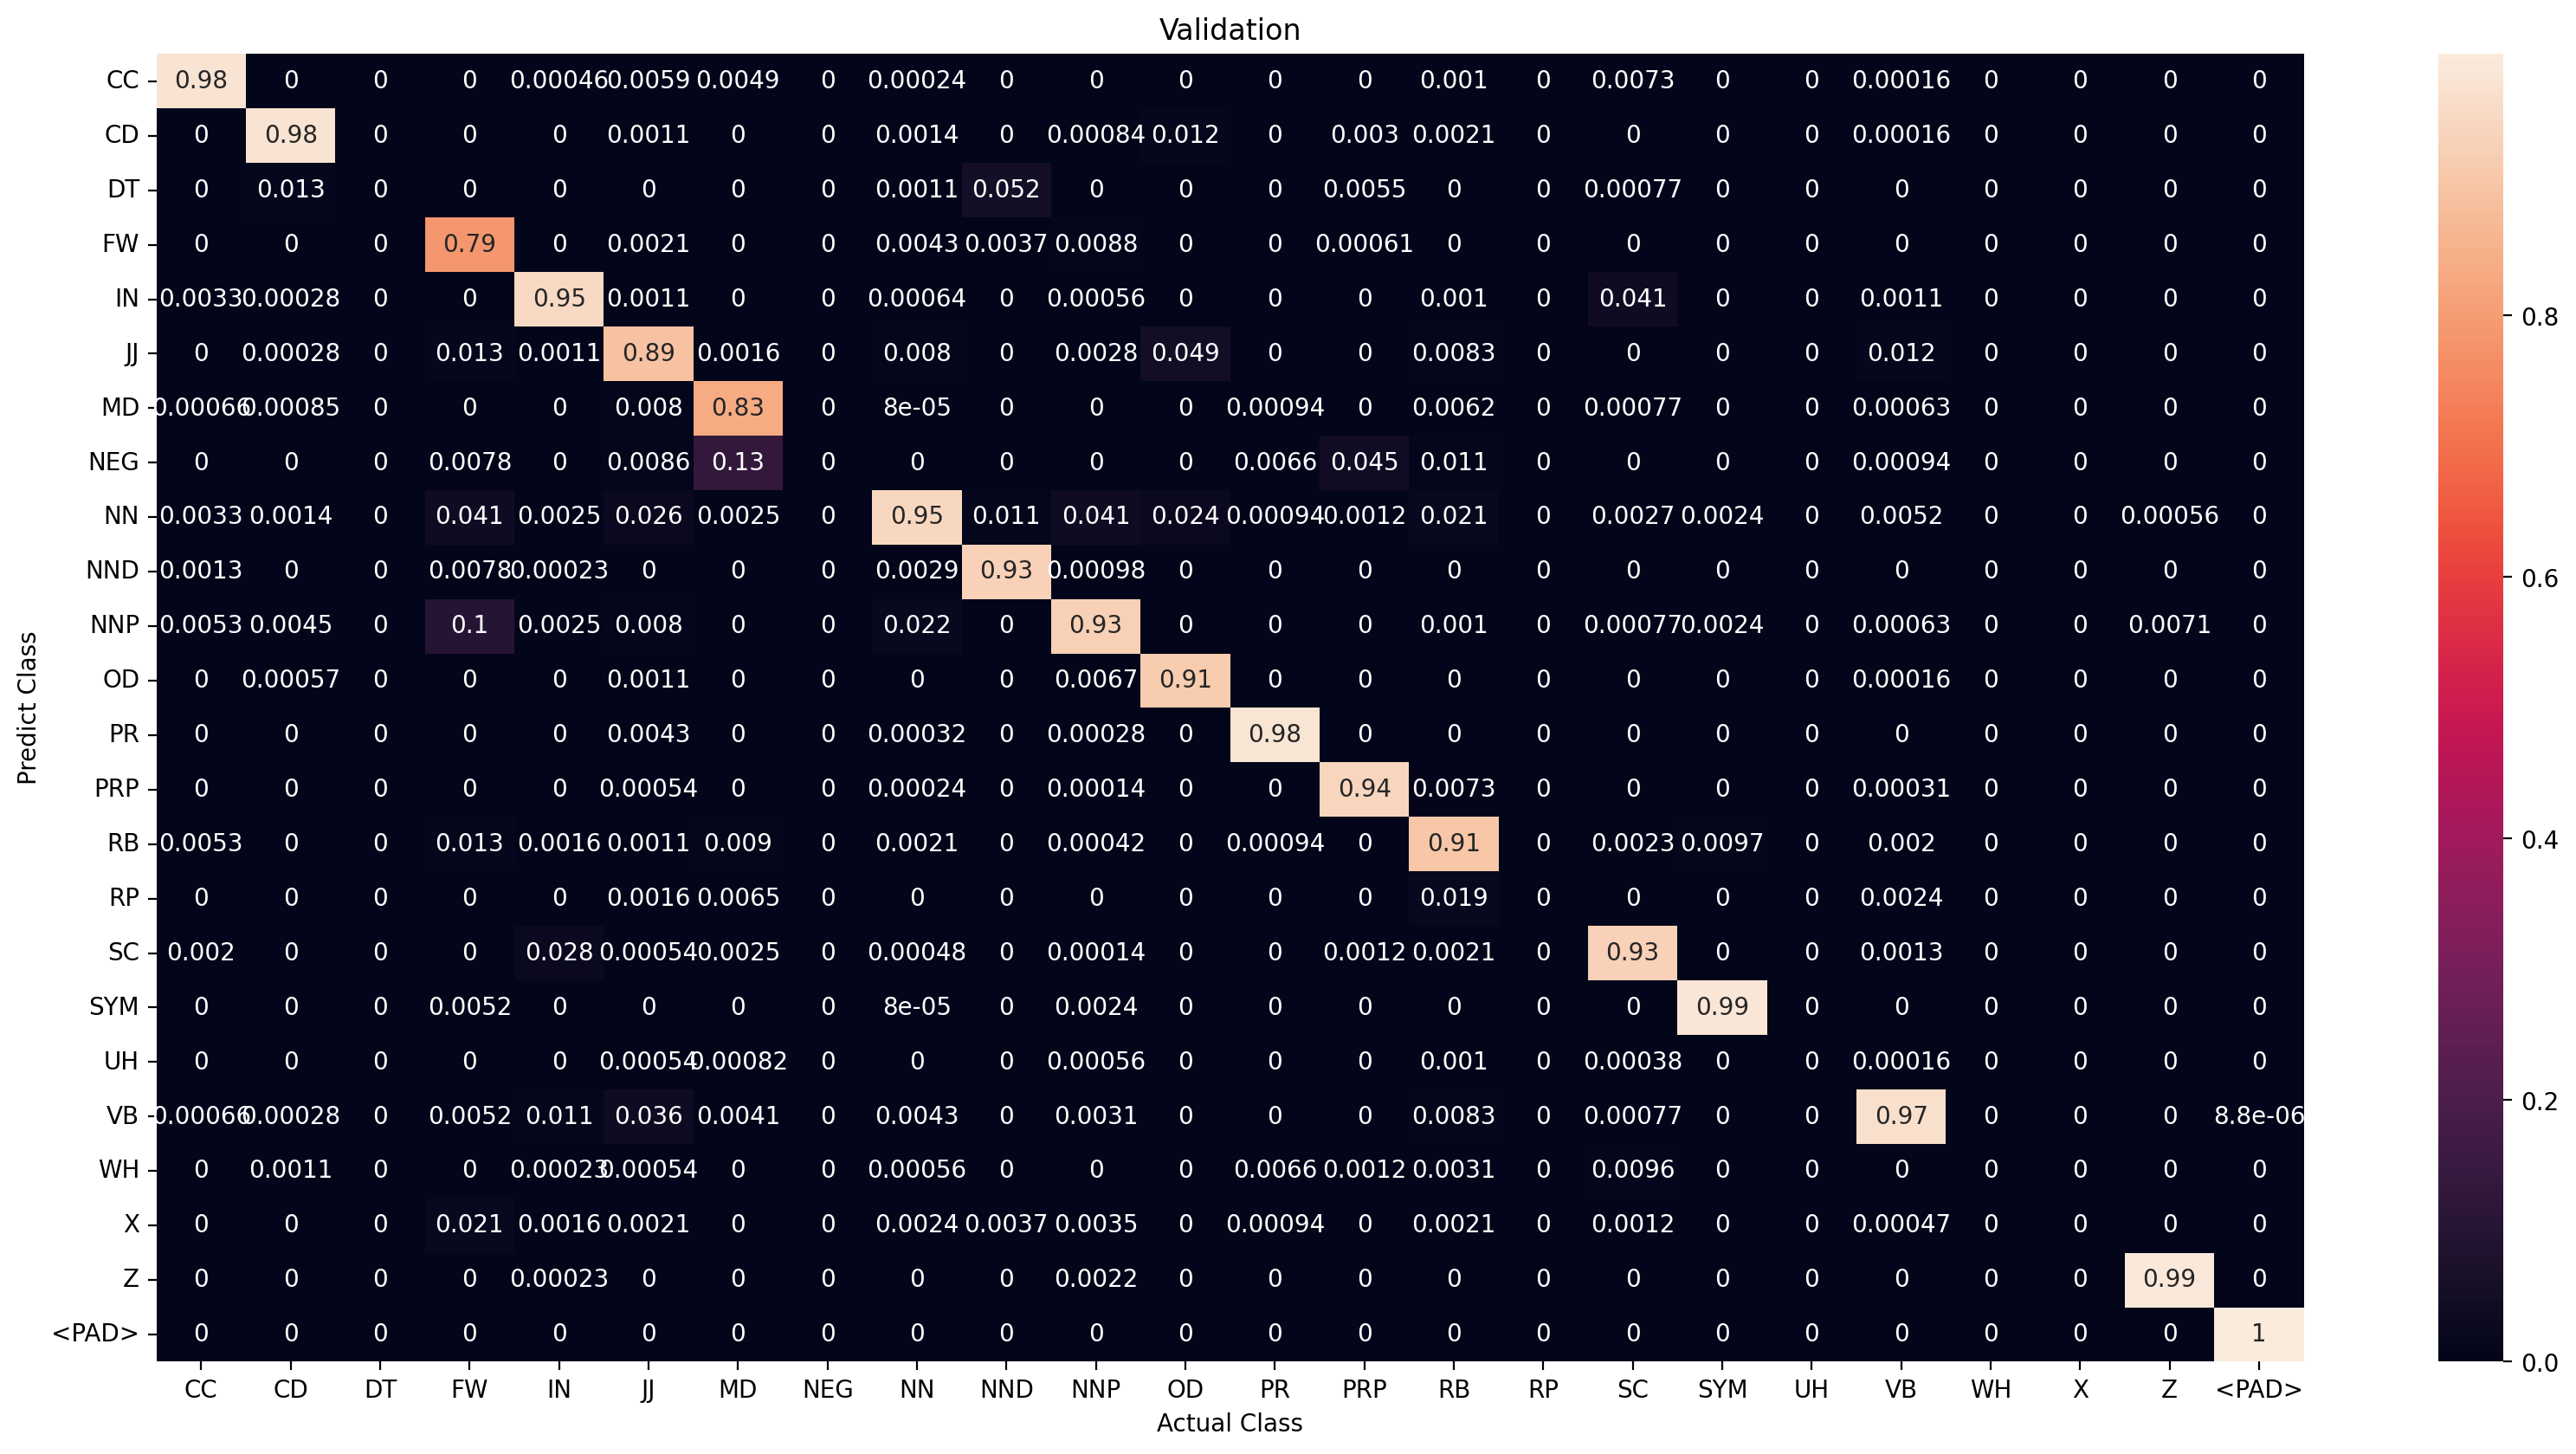

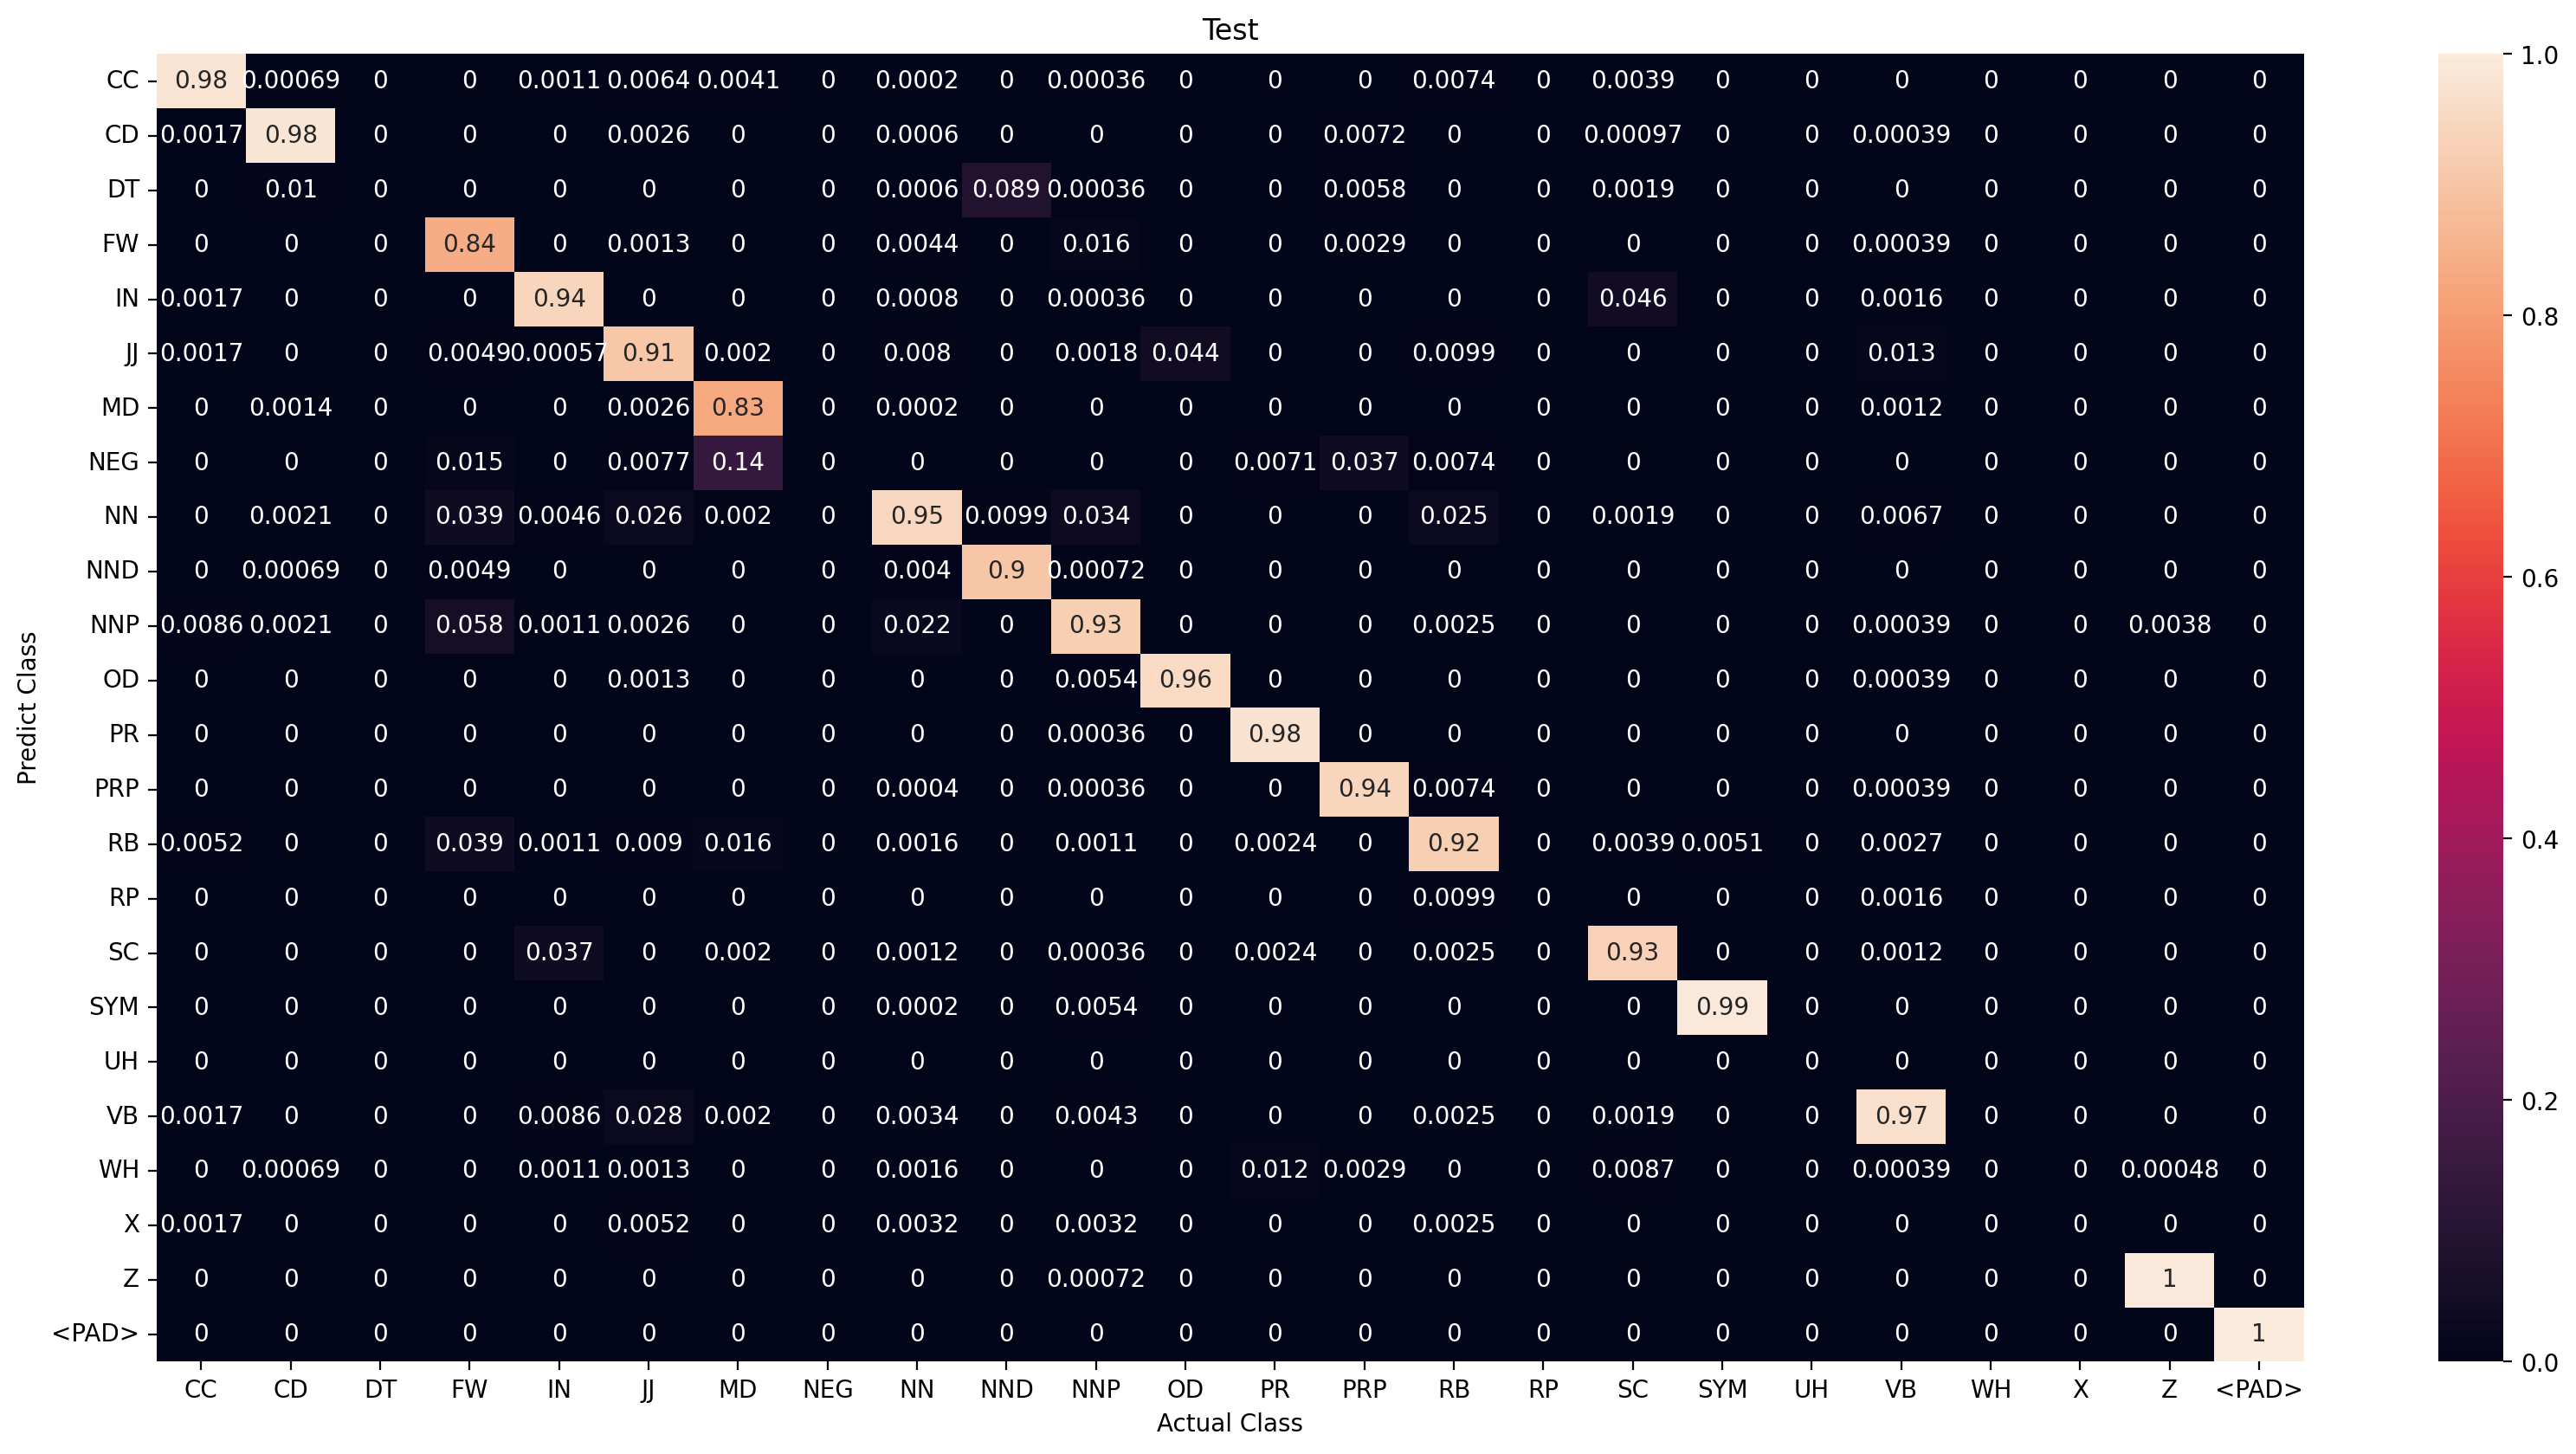

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5336   | CC    : 5213       | CC    : 123      |
| CD    : 12904  | CD    : 12826      | CD    : 78       |
| DT    : 263    | DT    : 0          | DT    : 263      |
| FW    : 1697   | FW    : 1462       | FW    : 235      |
| IN    : 15290  | IN    : 15144      | IN    : 146      |
| JJ    : 7049   | JJ    : 6640       | JJ    : 409      |
| MD    : 3783   | MD    : 3684       | MD    : 99       |
| NEG   : 1126   | NEG   : 0          | NEG   : 1126     |
| NN    : 44769  | NN    : 44245      | NN    : 524      |
| NND   : 998    | NND   : 837        | NND   : 161      |
| NNP   : 24884  | NNP   : 24469      | NNP   : 415      |
| OD    : 550    | OD    : 414        | OD    : 136      |
| PR    : 3878   | PR    : 3845       | PR    : 33       |
| PRP   : 5355   | PRP   : 5312       | PRP   : 43       |
| RB    : 3517   | RB    : 3356       | RB    : 161      |
| RP    : 131    | RP    : 0          | RP    : 131     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8,  5,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11934
Correct prediction          : 11286
Wrong prediction            : 648
Percentage correct oov pred : 94.57013574660633

Validation
Number OOV token            : 3261
Correct prediction          : 2955
Wrong prediction            : 306
Percentage correct oov pred : 90.6163753449862

Test
Number OOV token            : 1367
Correct prediction          : 1230
Wrong prediction            : 137
Percentage correct oov pred : 89.97805413313826



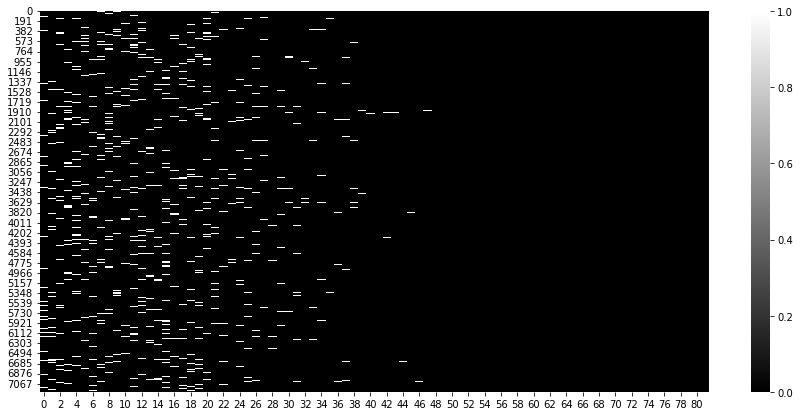

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

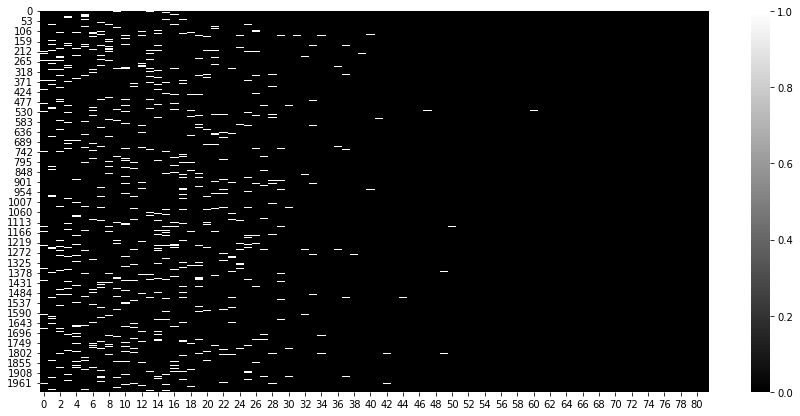

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

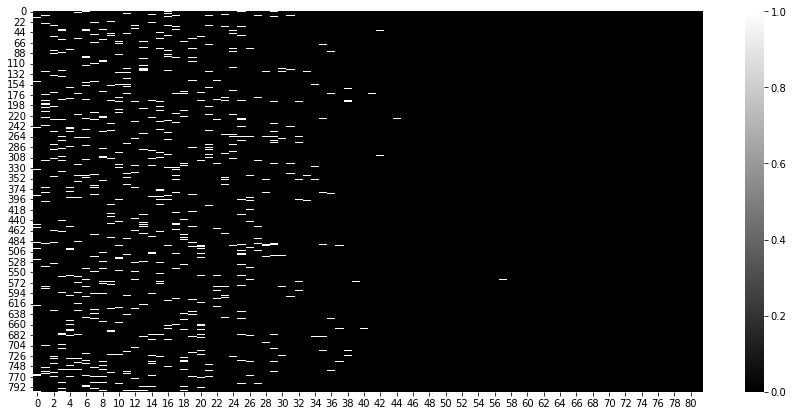

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);